In [1]:
import pandas as pd
import re
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline 
#generate side graph

In [2]:
artists = pd.read_csv(open("artists.csv"))
artworks = pd.read_csv(open("artworks.csv"))

# MoMA Acquisitions

The goal of this file is to answer one big question: **how should MoMA improve its future art acquisition?**

First, choose selective data into a new dataframe and classify donors into different types.
Overview the data number of rows and columns as well as data types

In [3]:
artwork = artworks[["Artwork ID", "Date","Acquisition Date","Credit","Department"]]
print(artwork.shape)
print(artwork.dtypes)

(130262, 5)
Artwork ID           int64
Date                object
Acquisition Date    object
Credit              object
Department          object
dtype: object


Second, classify donors into six categories with regex expressions

In [4]:
def donor_type(donor):
    if re.search(r'Gift',str(donor)) or re.search(r', gift',str(donor)) :
        return "Gift"
    elif re.search(r'^Purchase+$',str(donor)):
        return "Purchase"
    elif re.search(r'Purchase and partial gift',str(donor)) or re.search(r'partial gift',str(donor)):
        return "Purchase and partial gift"
    elif re.search(r'National Endowment',str(donor)):
        return "National Endowment"
    elif re.search(r'Given anonymously',str(donor)):
        return "Given anonymously"
    else:
        return "Other"

artwork['Donor Type'] = artwork['Credit'].apply(donor_type)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## Sub-question 1: What is the acquisition trend by year?

First, group artworks by donor types and summarize the counts. We can tell that artworks are given by gift most.

In [5]:
donor_counts = artwork.groupby("Donor Type").size()
print(donor_counts)

Donor Type
Gift                         66406
Given anonymously             1581
National Endowment             295
Other                        53490
Purchase                      8404
Purchase and partial gift       86
dtype: int64


Second, show how the acquisition date looks like. 
And extract the year and month from the column.

In [6]:
print(artwork["Acquisition Date"])
import datetime
#Since pandas represents timestamps in nanosecond resolution, 
#the timespan that can be represented using a 64-bit integer
#is limited to approximately 584 years (1677~2622)
artwork["Acquisition Cleaned"] = pd.to_datetime(artwork["Acquisition Date"], errors='coerce')
artwork["Acquisition Year"] = pd.DatetimeIndex(artwork["Acquisition Cleaned"]).year
artwork["Acquisition Month"] = pd.DatetimeIndex(artwork["Acquisition Cleaned"]).month
artwork["Acquisition Year_Month"] = pd.to_datetime(artwork["Acquisition Cleaned"]).dt.to_period('M')
artwork.head()

0         1996-04-09
1         1995-01-17
2         1997-01-15
3         1995-01-17
4         1997-01-15
             ...    
130257    2008-10-08
130258    2008-10-08
130259    2008-10-08
130260    2008-10-08
130261    2008-10-08
Name: Acquisition Date, Length: 130262, dtype: object


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,Artwork ID,Date,Acquisition Date,Credit,Department,Donor Type,Acquisition Cleaned,Acquisition Year,Acquisition Month,Acquisition Year_Month
0,2,1896,1996-04-09,Fractional and promised gift of Jo Carole and ...,Architecture & Design,Other,1996-04-09,1996.0,4.0,1996-04
1,3,1987,1995-01-17,Gift of the architect in honor of Lily Auchinc...,Architecture & Design,Gift,1995-01-17,1995.0,1.0,1995-01
2,4,1903,1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Architecture & Design,Gift,1997-01-15,1997.0,1.0,1997-01
3,5,1980,1995-01-17,Purchase and partial gift of the architect in ...,Architecture & Design,Purchase and partial gift,1995-01-17,1995.0,1.0,1995-01
4,6,1903,1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Architecture & Design,Gift,1997-01-15,1997.0,1.0,1997-01


In [7]:
from matplotlib.dates import DateFormatter

donor_by_year = artwork.groupby(['Acquisition Year',"Donor Type"]).agg('count').unstack()
donor_by_year.head()
#Only select one column in dataset
donor_by_year = donor_by_year["Artwork ID"]
donor_by_year.head()

Donor Type,Gift,Given anonymously,National Endowment,Other,Purchase,Purchase and partial gift
Acquisition Year,,,,,,
1929.0,9.0,NaN,NaN,NaN,NaN,NaN
1930.0,5.0,2.0,NaN,1.0,NaN,NaN
1931.0,3.0,NaN,NaN,NaN,NaN,NaN
1932.0,16.0,NaN,NaN,1.0,1.0,NaN
1933.0,95.0,NaN,NaN,NaN,NaN,NaN


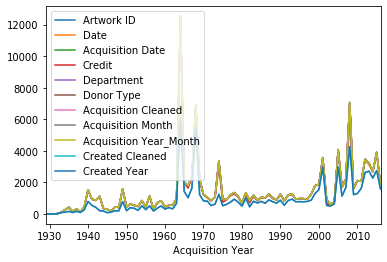

In [36]:
artwork.groupby(['Acquisition Year']).agg('count').plot()

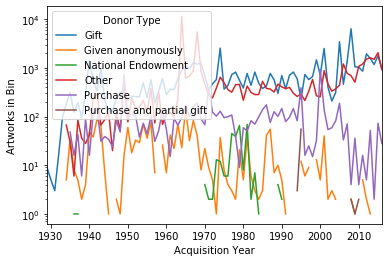

In [34]:
donor_by_year.plot()
#Since total amount of different donor types varies so large,
#I transform the counts into logarithmic
plt.yscale("log")
plt.ylabel("Artworks in Bin")
ax = plt.gca()

## Sub-question 2: What kind of art donors favor?

Similar coding to the first question but switched from line chart to histogram 

In [9]:
art_by_donor = artwork.groupby(["Donor Type",'Department']).agg('count').unstack()
art_by_donor.head()
#Only select one column in dataset
art_by_donor = art_by_donor["Artwork ID"]
art_by_donor.head()

Department,Architecture & Design,Architecture & Design - Image Archive,Drawings,Film,Fluxus Collection,Media and Performance Art,Painting & Sculpture,Photography,Prints & Illustrated Books
Donor Type,,,,,,,,,
Gift,13999.0,20.0,7427.0,988.0,2114.0,1140.0,1763.0,11417.0,27538.0
Given anonymously,217.0,NaN,190.0,1.0,NaN,9.0,131.0,99.0,934.0
National Endowment,4.0,NaN,82.0,4.0,NaN,NaN,13.0,133.0,59.0
Other,3750.0,1.0,2676.0,1978.0,21.0,1130.0,1682.0,13572.0,28680.0
Purchase,237.0,NaN,650.0,117.0,NaN,348.0,214.0,3936.0,2902.0


([<matplotlib.axis.YTick at 0x1151170d0>,
 <a list of 5 Text yticklabel objects>)

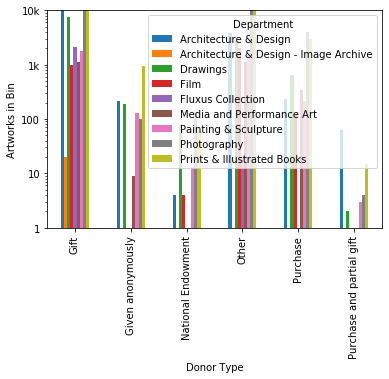

In [10]:
art_by_donor.plot(kind='bar')
# scale the bins to visualize as less skewed
plt.yscale("log")
plt.ylim(1,10000)
plt.xlabel("Donor Type")
plt.ylabel("Artworks in Bin")
plt.yticks([1, 10, 100, 1000, 10000], ["1", "10", "100", "1k", "10k"])

## Sub-question 3: When artworks are generally acquired after being created by donors?

First, I extracted artwork created year from original dataset into float type samed as cleaned artwork acquired year 

In [11]:
artwork["Created Cleaned"] = pd.to_datetime(artwork["Date"], errors='coerce')
artwork["Created Year"] = pd.DatetimeIndex(artwork["Created Cleaned"]).year
artwork.head()

/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

,Artwork ID,Date,Acquisition Date,Credit,Department,Donor Type,Acquisition Cleaned,Acquisition Year,Acquisition Month,Acquisition Year_Month,Created Cleaned,Created Year
0,2,1896,1996-04-09,Fractional and promised gift of Jo Carole and ...,Architecture & Design,Other,1996-04-09,1996.0,4.0,1996-04,1896-01-01,1896.0
1,3,1987,1995-01-17,Gift of the architect in honor of Lily Auchinc...,Architecture & Design,Gift,1995-01-17,1995.0,1.0,1995-01,1987-01-01,1987.0
2,4,1903,1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Architecture & Design,Gift,1997-01-15,1997.0,1.0,1997-01,1903-01-01,1903.0
3,5,1980,1995-01-17,Purchase and partial gift of the architect in ...,Architecture & Design,Purchase and partial gift,1995-01-17,1995.0,1.0,1995-01,1980-01-01,1980.0
4,6,1903,1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Architecture & Design,Gift,1997-01-15,1997.0,1.0,1997-01,1903-01-01,1903.0


Then, I plotted categorical variables in different donor types using Seaborn

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


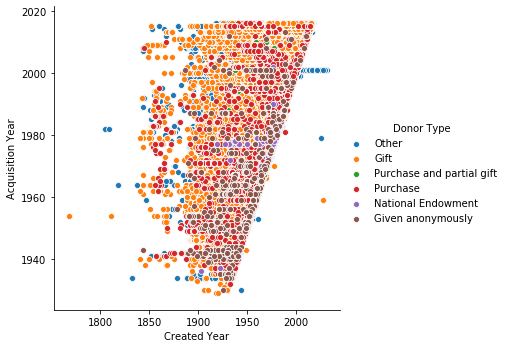

In [12]:
import seaborn as sns
#sns.pairplot(artwork, hue="Donor Type")
sns.pairplot(x_vars=["Created Year"], y_vars=["Acquisition Year"], data=artwork, hue="Donor Type", size=5)

Since the above chart is a little overlapped with different donor types, I created six scatterplots by each different donor type to double check the trend

Donor Type
Gift                         AxesSubplot(0.125,0.125;0.775x0.755)
Given anonymously            AxesSubplot(0.125,0.125;0.775x0.755)
National Endowment           AxesSubplot(0.125,0.125;0.775x0.755)
Other                        AxesSubplot(0.125,0.125;0.775x0.755)
Purchase                     AxesSubplot(0.125,0.125;0.775x0.755)
Purchase and partial gift    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

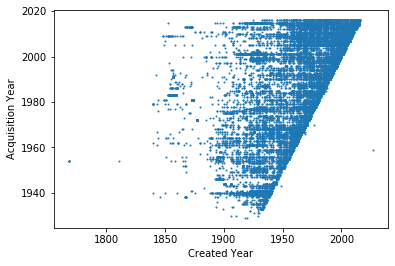

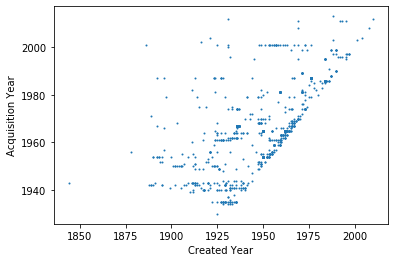

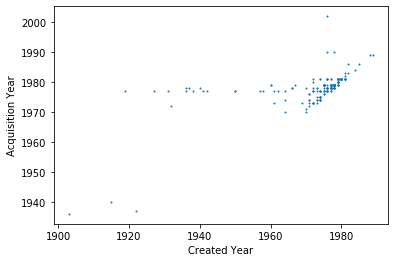

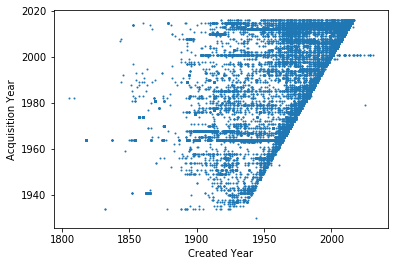

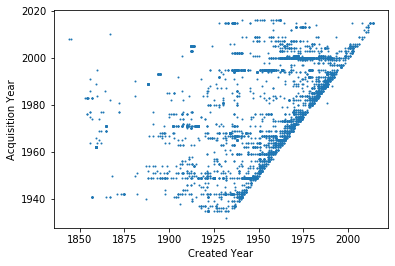

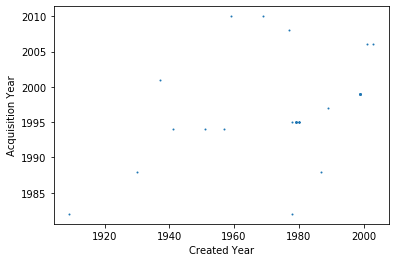

In [13]:
artwork.groupby("Donor Type").plot.scatter(x="Created Year",y="Acquisition Year", s=1)

## Sub-question 4: How many artworks will be acquired based on historical data?

First, transform data and prepare a dataset for regression analysis

In [14]:
df = artwork.loc[:, ["Acquisition Year", "Acquisition Month", "Donor Type"]]
monthly_df = df.groupby(["Acquisition Year", "Acquisition Month"]).agg('count')
monthly_df = monthly_df.reset_index()
print(monthly_df)

     Acquisition Year  Acquisition Month  Donor Type
0              1929.0               11.0           9
1              1930.0                1.0           3
2              1930.0                4.0           2
3              1930.0                6.0           1
4              1930.0               10.0           2
..                ...                ...         ...
742            2016.0                6.0         289
743            2016.0                9.0          41
744            2016.0               10.0         512
745            2016.0               11.0          99
746            2016.0               12.0          17

[747 rows x 3 columns]


In [15]:
monthly_df.columns = ["year", "month", "total"]
monthly_df["log_year"] = np.log(monthly_df["year"])
monthly_df["log_month"] = np.log(monthly_df["month"])
monthly_df.head()

,year,month,total,log_year,log_month
0,1929.0,11.0,9,7.564757,2.397895
1,1930.0,1.0,3,7.565275,0.000000
2,1930.0,4.0,2,7.565275,1.386294
3,1930.0,6.0,1,7.565275,1.791759
4,1930.0,10.0,2,7.565275,2.302585


Second, build 2 testing model to predict based on: 1) given year; 2) given year and month

In [29]:
import statsmodels.formula.api as smf
#Transform year to logarithmic value so that patterns are more interpretable
simple_model = smf.ols(formula = 'total ~ log_year', data=monthly_df).fit()
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.985
Date:                Sun, 05 Jan 2020   Prob (F-statistic):             0.0259
Time:                        19:43:39   Log-Likelihood:                -5750.4
No. Observations:                 747   AIC:                         1.150e+04
Df Residuals:                     745   BIC:                         1.151e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.71e+04   1.22e+04     -2.219      0.027   -5.11e+04   -3124.983
log_year    3592.3936   1608.952      2.233      0.026     433.773    6751.014
==============================================================================
Omnibus:                     1481.717   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2253610.279
Skew:                          14.512   Prob(JB):                         0.00
Kurtosis:                     270.512   Cond. No.                     4.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
nth_model = smf.ols(formula = 'total ~ log_year + log_month', data=monthly_df).fit()
month_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  total   No. Observations:                  747
Model:                            GLM   Df Residuals:                      744
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      2.8511e+05
Method:                          IRLS   Log-Likelihood:                -5749.8
Date:                Sun, 05 Jan 2020   Deviance:                   2.1212e+08
Time:                        19:43:40   Pearson chi2:                 2.12e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.65e+04   1.22e+04     -2.168      0.030   -5.05e+04   -2545.894
log_year    3508.0716   1610.646      2.178      0.029     351.264    6664.879
log_month     27.1229     25.033      1.083      0.279     -21.941      76.187
==============================================================================
"""

In [31]:
simple_model = smf.glm(formula = 'total ~ log_year', data=monthly_df).fit()
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  total   No. Observations:                  747
Model:                            GLM   Df Residuals:                      745
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      2.8518e+05
Method:                          IRLS   Log-Likelihood:                -5750.4
Date:                Sun, 05 Jan 2020   Deviance:                   2.1246e+08
Time:                        19:43:41   Pearson chi2:                 2.12e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.71e+04   1.22e+04     -2.219      0.026    -5.1e+04   -3163.928
log_year    3592.3936   1608.952      2.233      0.026     438.905    6745.882
==============================================================================
"""

In [32]:
month_model = smf.glm(formula = 'total ~ log_year + log_month', data=monthly_df).fit()
month_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  total   No. Observations:                  747
Model:                            GLM   Df Residuals:                      744
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      2.8511e+05
Method:                          IRLS   Log-Likelihood:                -5749.8
Date:                Sun, 05 Jan 2020   Deviance:                   2.1212e+08
Time:                        19:43:42   Pearson chi2:                 2.12e+08
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -2.65e+04   1.22e+04     -2.168      0.030   -5.05e+04   -2545.894
log_year    3508.0716   1610.646      2.178      0.029     351.264    6664.879
log_month     27.1229     25.033      1.083      0.279     -21.941      76.187
==============================================================================
"""

## Subquestion 5: Which model is a better fit?

The above answer only tells me the effects of year and month. I want to  predict the in-sample and out-of-sample modeling fit. First, the untrained data seems no difference between simple and monthly model. To double check, I evaluate mean squared errors for both.

Text(0.5, 0, 'Month in Dataset')

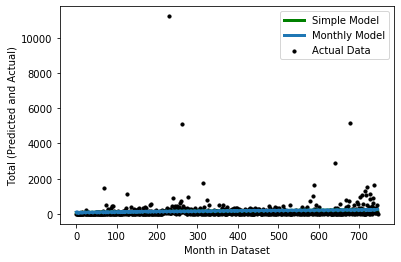

In [19]:
simple_predictions = simple_model.predict(monthly_df)
month_predictions = month_model.predict(monthly_df)

legend = []

legend.append("Simple Model")
plt.plot(monthly_df.index, simple_predictions, '-', linewidth=3, color="green")

legend.append("Monthly Model")
plt.plot(monthly_df.index, month_predictions, '-', linewidth=3)

legend.append("Actual Data")
plt.scatter(monthly_df.index, monthly_df.total, color="black", s=10)

plt.legend(legend)

plt.ylabel("Total (Predicted and Actual)")
plt.xlabel("Month in Dataset")
# 744 months in total in the dataframe within 99 years from 1920 to 2019

In [20]:
from sklearn.metrics import mean_squared_error
simple_r2 = simple_model.rsquared
month_r2 = month_model.rsquared
print(f"r^2 from simple model: {simple_r2:.2f}")
print(f"r^2 from monthly model: {month_r2:.2f}")

simple_rmse = np.sqrt(mean_squared_error(monthly_df.total, simple_predictions))
month_rmse = np.sqrt(mean_squared_error(monthly_df.total, month_predictions))
print(f"RMSE from simple model: {simple_rmse:.0f}")
print(f"RMSE from monthly model: {month_rmse:.0f}")

r^2 from simple model: 0.01
r^2 from monthly model: 0.01
RMSE from simple model: 533
RMSE from monthly model: 533


Second, to predict whether a model is better or worse at forecasting in the future, I defined a cutoff point and only train on data from prior to that point and then evaluated the model on data that came later

In [21]:
def train_and_evaluate_model(df, time_cutoff, formula, name):
    in_sample = df.iloc[:-time_cutoff]
    out_of_sample = df.iloc[-time_cutoff:]
    model = smf.ols(formula = formula, data=in_sample).fit()
    
    r2 = model.rsquared
    
    predictions = model.predict(out_of_sample)
    rmse = np.sqrt(mean_squared_error(out_of_sample.total, predictions))
    test_r2 = np.corrcoef(out_of_sample.total, predictions)[0][1]**2
    print(f"RMSE from {name} model on test: {rmse:.0f}")
    print(f"r^2 from {name} model on test: {test_r2:.3f}")
    results = {
        "rmse":rmse, 
        "r2":r2, 
        "predicted":predictions, 
        "actual":out_of_sample.total
    }
    return results
    
simple_results = train_and_evaluate_model(monthly_df, 12, 'total ~ log_year', "simple")
month_results = train_and_evaluate_model(monthly_df, 12, 'total ~ log_year + log_month', "monthly")

RMSE from simple model on test: 450
r^2 from simple model on test: 0.339
RMSE from monthly model on test: 447
r^2 from monthly model on test: 0.006


Text(0.5, 0.98, 'Predictions on Test Data')

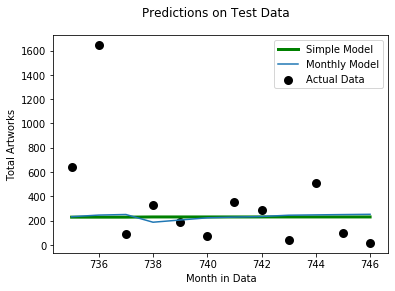

In [29]:
act = simple_results["actual"]
simple_pred = simple_results["predicted"]
month_pred = month_results["predicted"]

legend = []

legend.append("Simple Model")
plt.plot(simple_pred, color="green", linewidth=3)

legend.append("Monthly Model")
plt.plot(month_pred)

legend.append("Actual Data")
plt.scatter(simple_pred.index, act, color="black", linewidth=3)

plt.legend(legend)
plt.xlabel("Month in Data")
plt.ylabel("Total Artworks")
plt.suptitle("Predictions on Test Data")

So we got the following results in total:

| -       | In-Sample (Train) | -      | Out-of-Sample (Test) | -      |
|---------|-------------------|--------|---------------------|--------|
| **Model** | **r^2**         | **RMSE**| **r^2**            |**RMSE**   |
| Simple  | 0.01              |   533  | 0.339                | 450 |
| Monthly | 0.01              |   533  | 0.006                | 447 |

So what we see here is that given the data we have available, the additional complexity of the month-by-month model is not statistically any better than the model that only knows about the annual spike in August, no matter how we look at it; and depending on how you measure success, with only a few years of data available, you can argue that neither is statistically any more accurate at predicting the future than a simple linear model of growth.